In [1]:
from __future__ import division
from __future__ import print_function

import time
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from utils import load_data, test, train, accuracy
from models import GCN_2, GCN_3
from layers import GraphConvolution

In [2]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(path="../data/cora/", dataset="cora")

Loading cora dataset...


In [3]:
hidden = 16
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
num_epochs = 200
smooth_fac = 0.2

In [4]:
class ite_GCN(nn.Module):
    def __init__(self, nfeat, nclass, dropout, train_nite, eval_nite=0, allow_grad=True, smooth_fac=0):
        '''     
        - This model is a 1-layer GCN with nite iterations, followed by a linear layer and a log_softmax
            - GC layer:     nfeat to nfeat
            - linear layer: nfeat to nclass, (to cast hidden representations of nodes to a dimension of nclass)
        - Activation: ReLu
        - Input:
            - nfeat:        the number of features of each node
            - nclass:       the number of target classes (we are doing a node classification task here)
            - dropout:      dropout rate
            - train_nite:   the number of iterations during training
            - eval_nite:    the number of iterations during evaluation, 
                            if not specified (or invalid), intialize to the same as train_nite
            - allow_grad:   (bool) defaulted to True. 
                            whether or nor allow gradients to flow through all GC iterations, 
                            if False, gradients will only flow to the last iteration
            - smooth_fac:   a number in [0,1], smoothing factor, controls how much of the OLD iteration result is
                            counted in the skip connection in each iteration
                            for example, smooth_fac = x means y_{i+1} = x * y_i + (1-x) * y_{i+1}
                            Invalid inputs will be treated as 0.
        - Output:
            - A probability vector of length nclass, by log_softmax
        '''
        super(ite_GCN, self).__init__()

        self.gc = GraphConvolution(nfeat, nfeat)
        self.linear_no_bias = nn.Linear(nfeat, nclass, bias=False)
        self.dropout = dropout
        self.train_nite = train_nite
        self.allow_grad = allow_grad
        self.smooth_fac = smooth_fac
        self.eval_nite = eval_nite
        
        if (smooth_fac > 1) or (smooth_fac < 0):
            print("Invalid smoothing factor. Treat as 0.")
            self.smooth_fac = 0
        if (eval_nite <= 0):
            print("Unspecified or invalid number of iterations for inference. Treat as the same as training iterations.")
            self.eval_nite = self.train_nite
        
        print("Initialize a 1-layer GCN with ", self.train_nite, "iterations")
        print("Gradient flows to all iterations: ", allow_grad)

    def run_one_layer(self, x, adj):
        x_old = x
        x_new = self.gc(x, adj)
        x = F.relu(self.smooth_fac * x_old + (1 - self.smooth_fac) * x_new)
        x = F.dropout(x, self.dropout, training=self.training)
        return x

    def forward(self, x, adj):
        if self.training:
            for i in range(self.train_nite):
                if not self.allow_grad:
                    # print("no no no! new new")
                    x = x.detach()
                    x = self.run_one_layer(x, adj)
                    # x.requires_grad_()
                    # self.gc.weight.requires_grad_()
                    # self.gc.weight.retain_grad()
                    # print(self.gc.weight.requires_grad)
                    # for name, param in self.named_parameters():
                    #         print(name, param.grad)
                else:
                    # print("yea yea yea")
                    x = self.run_one_layer(x, adj)
                    # for name, param in self.named_parameters():
                    #         print(name, param.grad)
        else:
            for i in range(self.eval_nite):
                x = self.run_one_layer(x, adj)

        x = self.linear_no_bias(x)
        # self.gc.weight.requires_grad_()
        # print("???")
        # for name, param in self.named_parameters():
        #     if param.grad is not None:
        #         print(name, param.grad.abs().sum())
        return F.log_softmax(x, dim=1)
        

In [5]:
def run_experiment(num_epochs, model, lr, weight_decay, features, adj, idx_train, idx_val, idx_test, labels):
    print("runrunrun!")
    optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)
    t_total = time.time()
    loss_TRAIN = []
    acc_TRAIN = []
    loss_VAL = []
    acc_VAL = []
    for epoch in range(num_epochs):
        t = time.time()
    
        model.train()
        optimizer.zero_grad()
        
        output = model(features, adj)
        
        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        loss_TRAIN.append(loss_train)
        acc_train = accuracy(output[idx_train], labels[idx_train])
        acc_TRAIN.append(acc_train)

        # t3 = time.time()
        loss_train.backward()
        # t4 = time.time()
        # print("backward: ", t4-t3)
        # print("before step: ", model.gc.weight)
        optimizer.step()
        # print("after step: ", model.gc.weight)

        
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        # t1 = time.time()
        output = model(features, adj)
        # print("eval output: ", output)
        # t2 = time.time()
        # print("forward time: ", t2-t1)

        loss_val = F.nll_loss(output[idx_val], labels[idx_val])
        loss_VAL.append(loss_val)
        acc_val = accuracy(output[idx_val], labels[idx_val])
        acc_VAL.append(acc_val)
        print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'acc_train: {:.4f}'.format(acc_train.item()),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'acc_val: {:.4f}'.format(acc_val.item()),
            'time: {:.4f}s'.format(time.time() - t))
        

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    # Testing
    test(model, features, adj, idx_test, labels)
    return loss_TRAIN, acc_TRAIN, loss_VAL, acc_VAL

In [ ]:
model3 = ite_GCN(nfeat=features.shape[1],
            nclass=labels.max().item() + 1,
            dropout=dropout,
            train_nite = 3,
            allow_grad=True,
            smooth_fac=0.3)

# totally messed up

In [ ]:
loss_TRAIN, acc_TRAIN, loss_VAL, acc_VAL = run_experiment(num_epochs=200, model=model3, lr=lr, weight_decay=weight_decay, features=features, adj=adj, idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, labels=labels)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
l_t = []
for ten in loss_TRAIN:
    l_t.append(ten.item())

In [ ]:
plt.plot(l_t, 'r')

In [ ]:
a_t = []
for ten in acc_TRAIN:
    a_t.append(ten.item())

In [ ]:
plt.plot(a_t, 'r')

In [ ]:
l_v = []
for ten in loss_VAL:
    l_v.append(ten.item())

In [ ]:
plt.plot(l_v, 'r')

In [ ]:
a_v = []
for ten in acc_VAL:
    a_v.append(ten.item())

In [ ]:
plt.plot(a_v, 'r')

In [ ]:
model4 = ite_GCN(nfeat=features.shape[1],
            nclass=labels.max().item() + 1,
            dropout=dropout,
            train_nite = 3,
            allow_grad=False,
            smooth_fac=0.3)

In [ ]:
run_experiment(num_epochs=400, model=model4, lr=lr, weight_decay=weight_decay, features=features, adj=adj, idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, labels=labels)

In [ ]:
for name, param in model3.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().sum())

In [ ]:
model1 = GCN_3(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout)

In [6]:
model2 = ite_GCN(nfeat=features.shape[1],
            nclass=labels.max().item() + 1,
            dropout=0,
            train_nite= 2,
            eval_nite= 0,
            allow_grad=True,
            smooth_fac=smooth_fac)
run_experiment(num_epochs, model2, lr, weight_decay, features, adj, idx_train, idx_val, idx_test, labels)


Unspecified or invalid number of iterations for inference. Treat as the same as training iterations.
Initialize a 1-layer GCN with  2 iterations
Gradient flows to all iterations:  True
runrunrun!
Epoch: 0001 loss_train: 1.9463 acc_train: 0.2000 loss_val: 1.8221 acc_val: 0.3500 time: 0.4371s
Epoch: 0002 loss_train: 1.8292 acc_train: 0.2929 loss_val: 2.0807 acc_val: 0.3500 time: 0.3771s
Epoch: 0003 loss_train: 2.1051 acc_train: 0.2929 loss_val: 1.7790 acc_val: 0.3500 time: 0.3797s
Epoch: 0004 loss_train: 1.7740 acc_train: 0.2929 loss_val: 1.8437 acc_val: 0.3500 time: 0.3782s
Epoch: 0005 loss_train: 1.8328 acc_train: 0.2929 loss_val: 1.8414 acc_val: 0.3500 time: 0.3758s
Epoch: 0006 loss_train: 1.8273 acc_train: 0.2929 loss_val: 1.7934 acc_val: 0.3500 time: 0.3801s
Epoch: 0007 loss_train: 1.7722 acc_train: 0.2929 loss_val: 1.7071 acc_val: 0.3500 time: 0.3750s
Epoch: 0008 loss_train: 1.6709 acc_train: 0.2929 loss_val: 1.6272 acc_val: 0.3500 time: 0.3811s
Epoch: 0009 loss_train: 1.5764 acc_t

([tensor(1.9463, grad_fn=<NllLossBackward0>),
  tensor(1.8292, grad_fn=<NllLossBackward0>),
  tensor(2.1051, grad_fn=<NllLossBackward0>),
  tensor(1.7740, grad_fn=<NllLossBackward0>),
  tensor(1.8328, grad_fn=<NllLossBackward0>),
  tensor(1.8273, grad_fn=<NllLossBackward0>),
  tensor(1.7722, grad_fn=<NllLossBackward0>),
  tensor(1.6709, grad_fn=<NllLossBackward0>),
  tensor(1.5764, grad_fn=<NllLossBackward0>),
  tensor(1.4373, grad_fn=<NllLossBackward0>),
  tensor(1.3436, grad_fn=<NllLossBackward0>),
  tensor(1.2215, grad_fn=<NllLossBackward0>),
  tensor(1.1095, grad_fn=<NllLossBackward0>),
  tensor(0.9965, grad_fn=<NllLossBackward0>),
  tensor(0.8795, grad_fn=<NllLossBackward0>),
  tensor(0.7624, grad_fn=<NllLossBackward0>),
  tensor(0.6655, grad_fn=<NllLossBackward0>),
  tensor(0.5517, grad_fn=<NllLossBackward0>),
  tensor(0.4700, grad_fn=<NllLossBackward0>),
  tensor(0.4049, grad_fn=<NllLossBackward0>),
  tensor(0.3456, grad_fn=<NllLossBackward0>),
  tensor(0.3004, grad_fn=<NllLossB

In [10]:
test_losses = []
test_accuracies = []

for i in range(1, 30):
    model = ite_GCN(nfeat=features.shape[1],
            nclass=labels.max().item() + 1,
            dropout=0,
            train_nite= 3,
            eval_nite= i,
            allow_grad=True,
            smooth_fac=smooth_fac)
    model.load_state_dict(model2.state_dict().copy())
    loss_test, acc_test = test(model, features, adj, idx_test, labels)
    test_losses.append(loss_test.item())
    test_accuracies.append(acc_test.item())


Initialize a 1-layer GCN with  3 iterations
Gradient flows to all iterations:  True
Test set results: loss= 1.7943 accuracy= 0.1620
inference time:  0.1115729808807373
Initialize a 1-layer GCN with  3 iterations
Gradient flows to all iterations:  True
Test set results: loss= 0.7120 accuracy= 0.7780
inference time:  0.1319718360900879
Initialize a 1-layer GCN with  3 iterations
Gradient flows to all iterations:  True
Test set results: loss= 8.1743 accuracy= 0.3420
inference time:  0.1900501251220703
Initialize a 1-layer GCN with  3 iterations
Gradient flows to all iterations:  True
Test set results: loss= 27.2977 accuracy= 0.3540
inference time:  0.2713141441345215
Initialize a 1-layer GCN with  3 iterations
Gradient flows to all iterations:  True
Test set results: loss= 204.8581 accuracy= 0.2110
inference time:  0.4239051342010498
Initialize a 1-layer GCN with  3 iterations
Gradient flows to all iterations:  True
Test set results: loss= 722.1061 accuracy= 0.2390
inference time:  0.3911

In [15]:
test_losses

[1.7942862510681152,
 0.711990475654602,
 8.17428970336914,
 27.297683715820312,
 204.85812377929688,
 722.1061401367188,
 3141.895263671875,
 11322.13671875,
 44796.00390625,
 171245.703125,
 704483.25,
 2887993.75,
 12310760.0,
 52552016.0,
 226961440.0,
 981502208.0,
 4266723584.0,
 18556422144.0,
 80865419264.0,
 352760954880.0,
 1540183949312.0,
 6730026057728.0,
 29446335627264.0,
 128836729569280.0,
 563716135321600.0,
 2467533068173312.0,
 1.0807344602546176e+16,
 4.73268845847511e+16,
 2.0733367069913907e+17]

In [16]:
test_accuracies

[0.162,
 0.778,
 0.342,
 0.354,
 0.211,
 0.239,
 0.175,
 0.206,
 0.168,
 0.281,
 0.286,
 0.293,
 0.287,
 0.293,
 0.293,
 0.301,
 0.294,
 0.301,
 0.3,
 0.299,
 0.291,
 0.275,
 0.268,
 0.259,
 0.251,
 0.244,
 0.228,
 0.211,
 0.196]

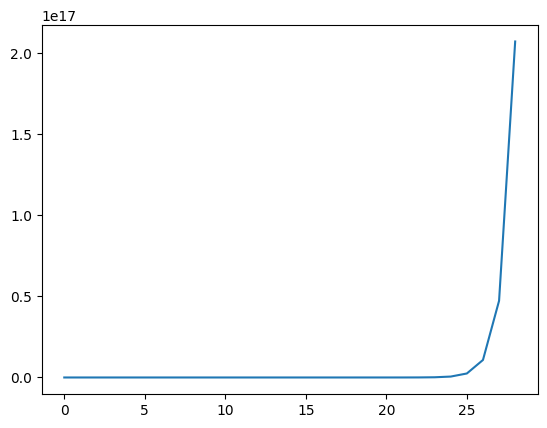

In [13]:
import matplotlib.pyplot as plt
plt.plot(test_losses)


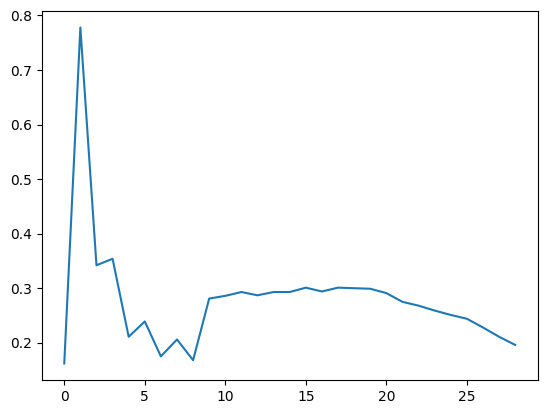

In [14]:
plt.plot(test_accuracies)

In [23]:
a = np.arange(10)


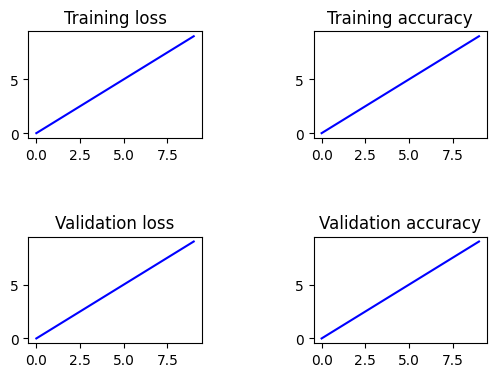

In [26]:
fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=5.0)
ax[0, 0].plot(a, 'b') #row=0, col=0
ax[0, 0].title.set_text("Training loss")
ax[0, 1].plot(a, 'b') #row=0, col=1
ax[0, 1].title.set_text("Training accuracy")
ax[1, 0].plot(a, 'b') #row=1, col=0
ax[1, 0].title.set_text("Validation loss")
ax[1, 1].plot(a, 'b') #row=1, col=1
ax[1, 1].title.set_text("Validation accuracy")
plt.show()